# Kaggle 入门 1 - 泰坦尼克号幸存者预测问题

描述：是一个分类问题，目标变量是离散型变量，1 表示幸存 Survived ，0 表示遇难。

参考资料：https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

首先我们看一看数据。

## 读取数据

In [16]:
import pandas as pd

train = pd.read_csv('../Datasets/titanic/train.csv')
test = pd.read_csv('../Datasets/titanic/test.csv')

数据刚拿到的时候，我们常常使用 `train.shape` 、 `train.head()` 和 `train.describe()` 看一看数据长啥样，有多少个数据，多少个特征。

关注点：

1、字段的含义，此时要反复看 Kaggle 的问题列表，最好能翻译一下每个变量的含义，看到这个字段你要明白它表示什么。

关注点1：离散型还是连续型：
离散型：性别、国家、月份
连续型：身高、体重、价格

利用好这些字段的含义，你才有可能知道这些字段对于你要做的问题有啥帮助。

泰坦尼克号问题的字段含义：

1、PassengerId => 乘客 ID ，离散型
2、Pclass => 乘客等级（1/2/3等舱位），离散型，有序
3、Name => 乘客姓名， 离散型
4、Sex => 性别，离散型
5、Age => 年龄，连续型，整型
6、SibSp => 与乘客一起旅行的兄弟姐妹和配偶的数量，连续型，整型
7、Parch => 与乘客一起旅行的父母和孩子的数量，连续型，整型
8、Ticket => 船票号码，是一串文字，离散型
9、Fare => 票价，连续型
10、Cabin => 客舱，离散型
11、Embarked => 登船港口，离散型

发现好多离散型变量。连续型变量只有 $4$ 个：Age（年龄）、Fare（票价）、SibSp、Parch，其中，只有 `Fare` 是浮点型，其它 3 个变量都是整数型。




In [23]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
# Age 字段有很 177 个缺失值
sum(train['Age'].isnull())

177

缺失值的填充方法有很多：

1、平均数填充，可能是用得最多的；

2、众数填充；  

3、中位数填充；

使用中位数进行填充更为稳健，平均数比较容易受极端值影响。

4、使用机器学习算法把缺失值作为目标变量进行预测。

我们先使用中位数填充。

In [261]:
# 为了简单起见，先使用中位数填充，后面我们有更合理的填充年龄缺失数据的方法
train['Age'].median()

28.0

In [29]:
train['Age'] = train['Age'].fillna(train['Age'].median())
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 探索性数据分析（EDA）

EDA ，即 Exploratory Data Analysis ，这一步比较靠经验了。不过也有一定套路。对于泰坦尼克号问题比较简单，就是单独把字段和目标变量拿出来，分析它们之间的关系，即看看那一些特征对于最终我们要预测的变量有关。

> EDA 的目的，我个人觉得就是在验证我们对问题的猜想，就想我们觉得一个人是否能够考上好大学，跟这个人的家庭教育程度有关，那么我们就会去调查这个人父母的受教育程度，通过各种手段来验证我们的猜想，这方面严格的、科学的方式是使用“数理统计”学中“假设检验”的方法，但是初学数据分析的时候，我们往往可以先通过绘图，直观地进行判断（就想其实是一些板上定钉的事情，我们可以先不加严格证明先使用它，绘图具有说服力就好）。

我们常常使用绘图的方式，来验证我们的猜测，因为这样更直观。但实际上，使用“数理统计”中的“假设检验”的知识更加合理（这方面的理论基础我还很薄弱，还要加强学习）。

+ 这一步往往要根据目标变量的定义和问题场景，进行“猜测”，然后绘图验证我们的猜想。



### 猜测：性别是一个和幸存有关的很重要的变量

首先，要注意到 `Sex` 是离散型分类变量，只有两个取值：`male` 和 `female`。

In [35]:
train['Sex'].unique()

array(['male', 'female'], dtype=object)



外国人常以“女士优先”，有“绅士风度”，即使是在生死攸关的问题上也是这样。因此我们有理由猜测“男士”会让“女人”和“孩子”先上救生艇，实际上电影也是这么演的。盗个图感慨一下。

![](https://ahmedbesbes.com/images/article_1/titanic.jpg)



下面我们就按照“性别”分类，看一看“男”和“女”幸存和死亡的比例，就很清楚了。

In [36]:
# 我一开始想到用 count ，后来发现不对，count 是计数，只要不是空，都记 1 ，所以，应该使用 sum
train.groupby('Sex').count()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
Sex,,,,,,,,,,,,
female,314,314,314,314,314,314,314,314,314,97,312,314
male,577,577,577,577,577,577,577,577,577,107,577,577


In [37]:
# 为了绘图方便，我们设置一个 `Died` 变量，表示“死亡”，`Survived` 是 1 的，它就是 0，与 Survived 相反，马上我们会用到。
train['Died'] = 1 - train['Survived']
train[['Survived', 'Died']].head()

,Survived,Died
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [40]:
train.groupby('Sex').agg('sum')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Died
Sex,,,,,,,,
female,135343,233,678,8770.00,218,204,13966.6628,81
male,262043,109,1379,17391.17,248,136,14727.2865,468


没错了，`Survived` 和 `Died` 就是我们要的，把它们单独拿出来。只是为了比较数值，即比较“高矮”，所以画条形图就可以了。

In [46]:
train.groupby('Sex').agg('sum')[['Survived', 'Died']]

,Survived,Died
Sex,,
female,233,81
male,109,468


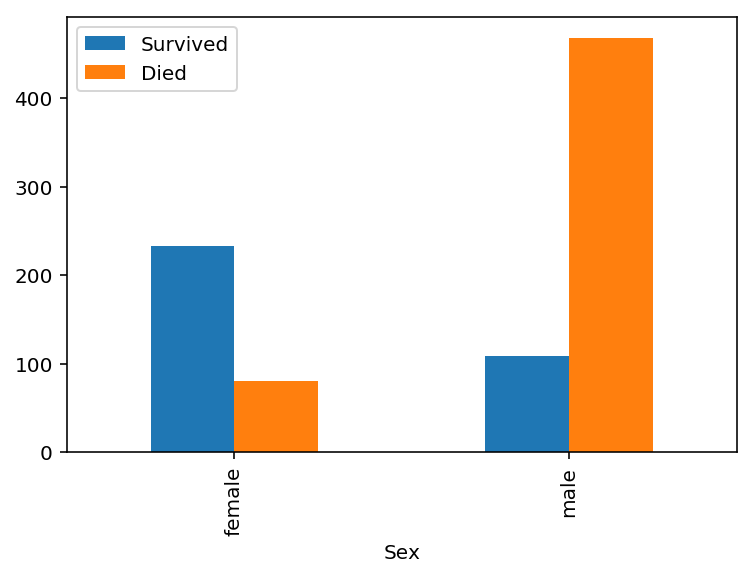

In [45]:
train.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar')
plt.show()

我觉着这个颜色对比不够鲜明。“遇难”是一个悲剧，用红色来表示，“幸存”是运气很好，就用“绿色”吧。再改改。把 `color` 属性写进去，注意对应关系，`Survived` 对应绿色，`Died` 对应红色，所以 `color=['g', 'r']`。

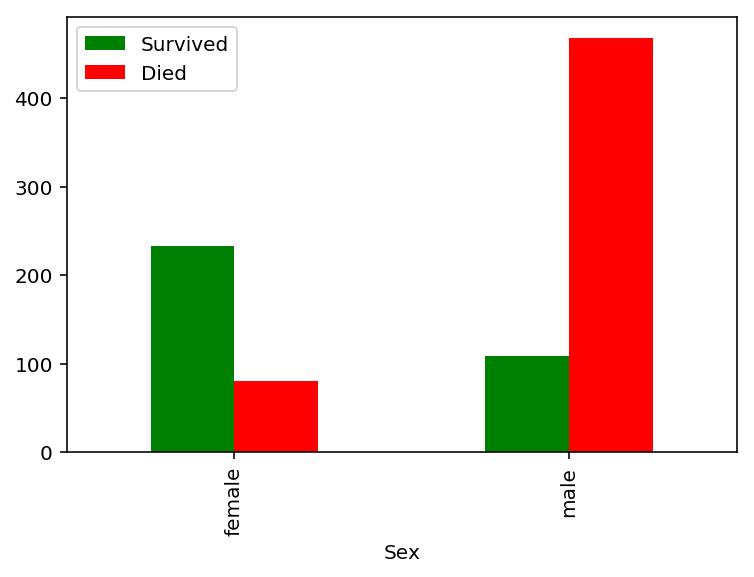

In [47]:
train.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(
    kind='bar', color=['g', 'r'])
plt.show()

我对英文不太敏感，所以想把 `female` 和 `male` 也换掉。

In [57]:
train_sex_group = train.groupby('Sex').agg('sum')[['Survived', 'Died']]
train_sex_group.index = ['女士','男士']
train_sex_group.columns = ['幸存','死亡']
train_sex_group

,幸存,死亡
女士,233,81
男士,109,468


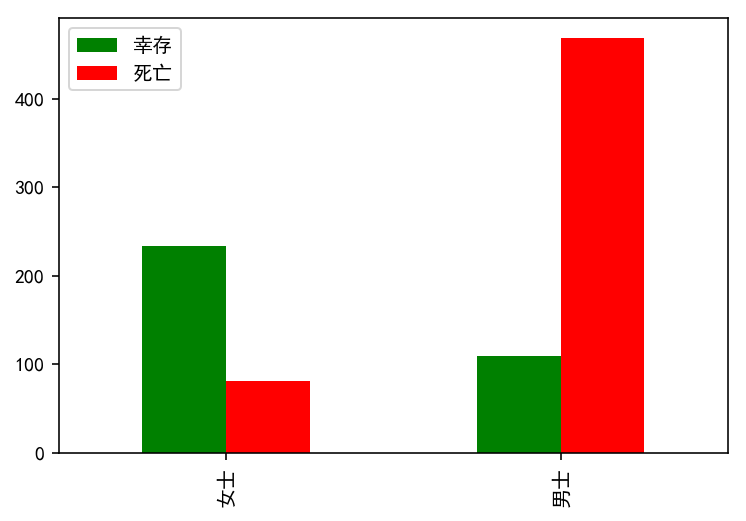

In [58]:
# 我这边为了显示中文和负号，要加上下面这 3 行，也是很奇迹了
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

train_sex_group.plot(kind='bar', color=['g', 'r'])
plt.show()

费了些功夫，画了这张图，的确是很清晰了，女士里面幸存的多，男士当中有很大一部分都不幸罹难了。

这一部分其实可以使用卡方检验，进一步验证我们的猜想。

In [61]:
from scipy.stats import chi2_contingency

chi2_contingency(train_sex_group.values)

(260.71702016732104,
 1.1973570627755645e-58,
 1,
 array([[120.52525253, 193.47474747],
        [221.47474747, 355.52525253]]))

可以看到 $p$ 值为 $1.1973570627755645e-58$，远小于 $0.05$，因此“性别”和“幸存”的确不是独立的，“性别”是一项预测“是否幸存”的重要特征。

### 猜测：年龄和是否幸存有关

这一点几乎是显然的，青壮年身体好，行动方便，逃生中占优势。

注意到年龄是一个连续型的变量，所以我们可以分别看看“幸存”的人和“遇难”的人的年龄分布。


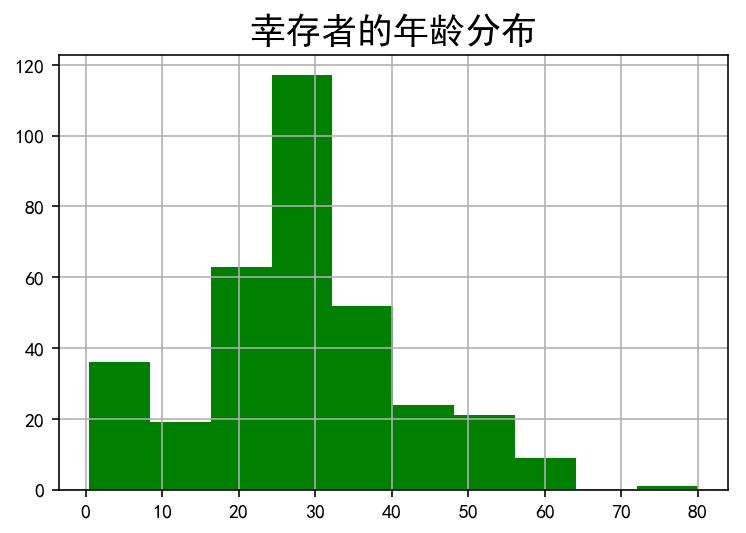

In [73]:
train[train['Survived'] == 1]['Age'].hist(color='g')
plt.title('幸存者的年龄分布', size=18)
plt.show()

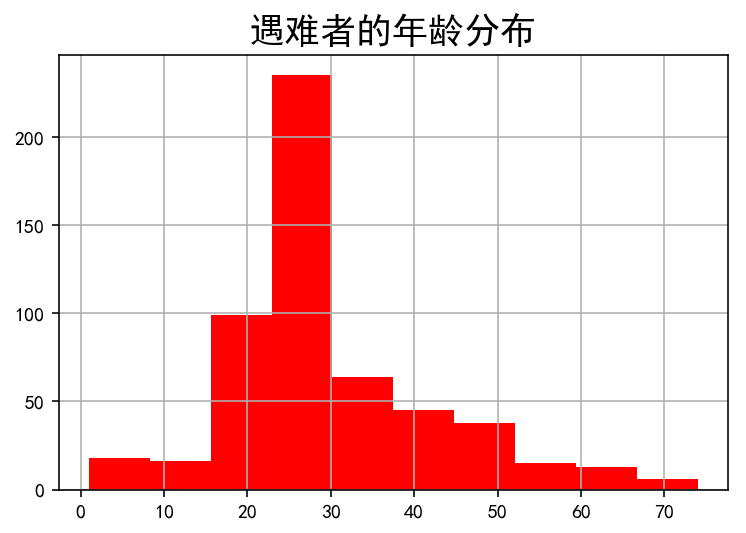

In [75]:
train[train['Survived'] == 0]['Age'].hist(color='r')
plt.title('遇难者的年龄分布', size=18)
plt.show()

In [76]:
train_age = pd.read_csv('../Datasets/titanic/train.csv')

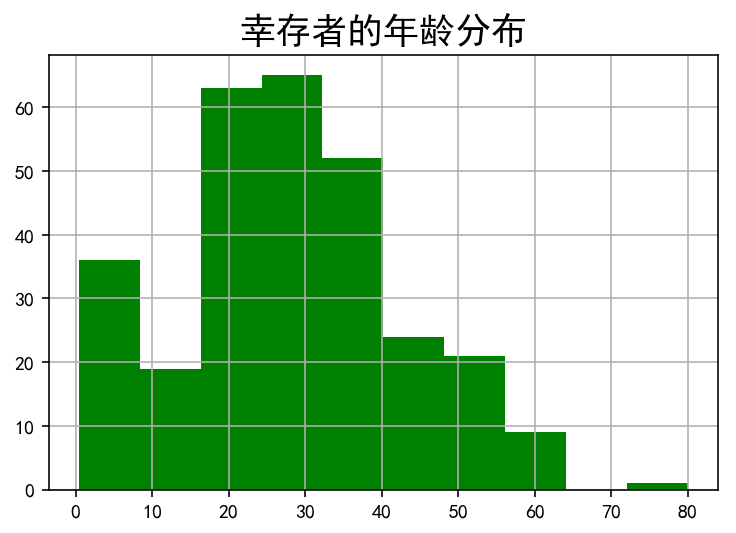

In [77]:
train_age[train_age['Survived'] == 1]['Age'].hist(color='g')
plt.title('幸存者的年龄分布', size=18)
plt.show()

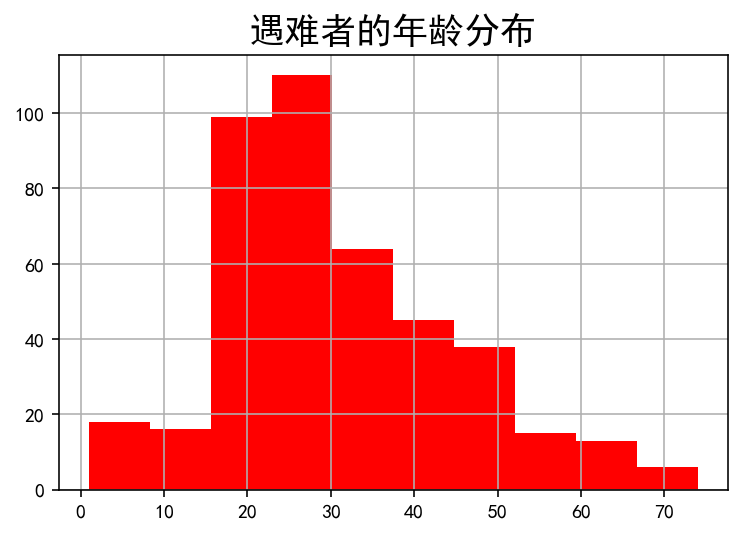

In [79]:
train_age[train_age['Survived'] == 0]['Age'].hist(color='r')
plt.title('遇难者的年龄分布', size=18)
plt.show()

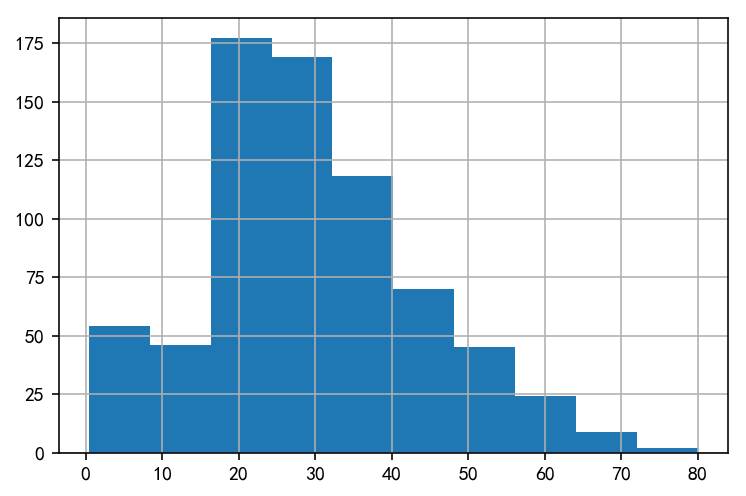

In [87]:
train_age['Age'].dropna().hist()

居然都差不多，会不会是本来 30-40 的人就比较多。可以分箱试试看。pandas 的 cut 函数。

或者是我按照我原来的想法，把年龄按照老、中、青分类，然后看看离散化以后的年龄特征对是否幸存的影响。

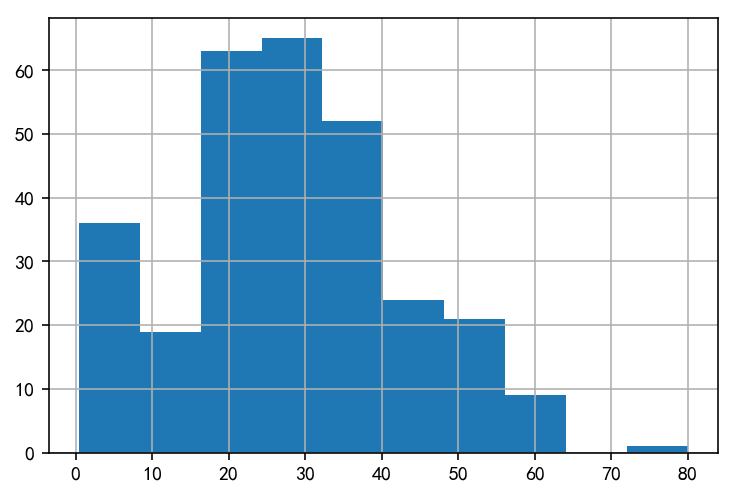

In [119]:
train_age['Age'][np.logical_and(train_age['Age'].notnull().values,
                                (train_age['Survived'] == 1).values)].hist()

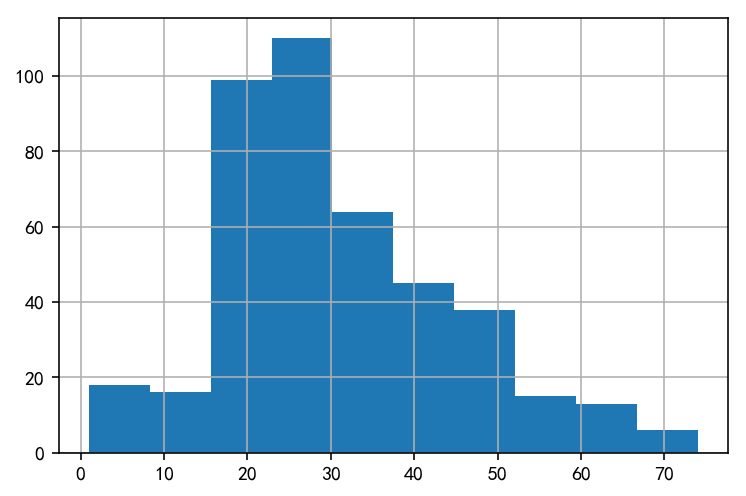

In [120]:
train_age['Age'][np.logical_and(train_age['Age'].notnull().values,
                                (train_age['Survived'] == 0).values)].hist()

In [129]:
# 只统计年龄非空的人的数据
train_age[~np.isnan(train_age['Age'])]['Age'].shape

(714,)

In [132]:
# 上面的代码写得没有错，Age 非空有 714 人
train_age.describe()['Age']

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [154]:
def age_group(x):
    if x <= 16:
        return 'child'
    elif x <= 30:
        return 'young'
    elif x <= 55:
        return 'midlife'
    else:
        return 'old'


# train_age[~np.isnan(train_age['Age'])]['Age'].map(age_group)

In [155]:
train_age_survived = train_age[~np.isnan(train_age['Age'])][[
    'Age', 'Survived'
]]
train_age_survived['age_group'] = train_age_survived['Age'].map(age_group)
train_age_survived.head()

,Age,Survived,age_group
0,22.0,0,young
1,38.0,1,midlife
2,26.0,1,young
3,35.0,1,midlife
4,35.0,0,midlife


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


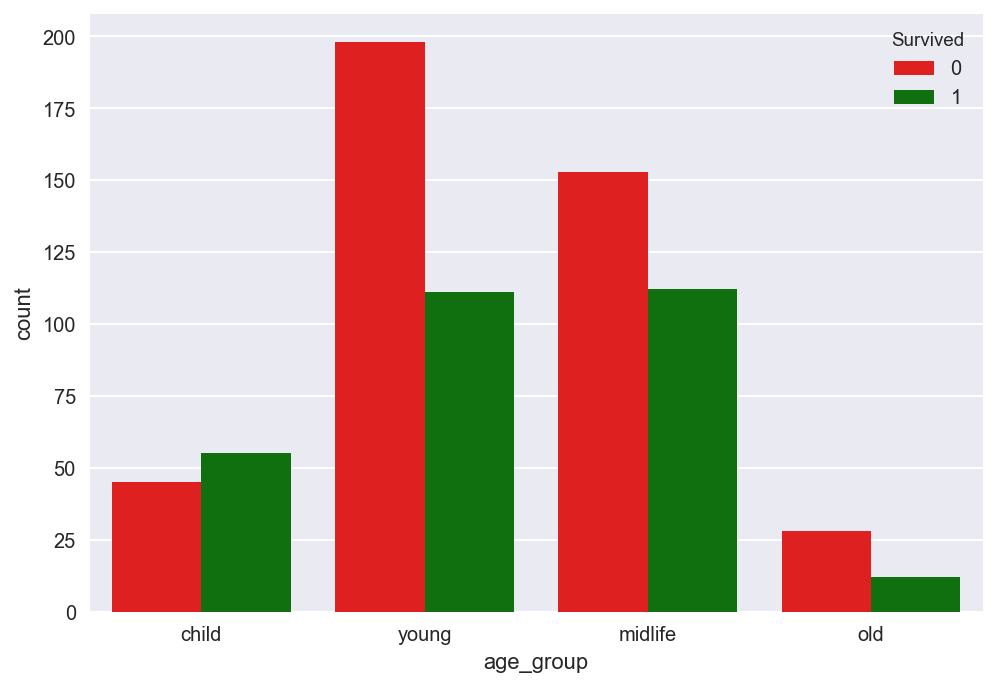

In [157]:
import seaborn as sns

sns.countplot(
    x='age_group',
    hue='Survived',
    data=train_age_survived,
    order=['child', 'young', 'midlife', 'old'],
    palette={
        0: "r",
        1: "g"
    })
plt.show()

有点意外，年轻人遇难的比例大一些，可能是因为 16 到 30 这个阶段的年轻人乘坐泰坦尼克号都是自己单独出来的，没有结伴而行，他们的社会地位和经济实力都还在积累计算，还比较低，并且在让“老人、孩子、女士”优先的指导下，他们选择了“牺牲”，他们能获得的帮助少一些。

不管怎么说吧，我们还是会考虑“年龄”（或者“年龄段”）这个特征。

### 猜测：票价和幸存有关

我们的常识告诉我们票价越高，所在的环境人越少，获救的可能性越大。

票价是连续型变量，所以可以画箱线图，看看分布。

In [159]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


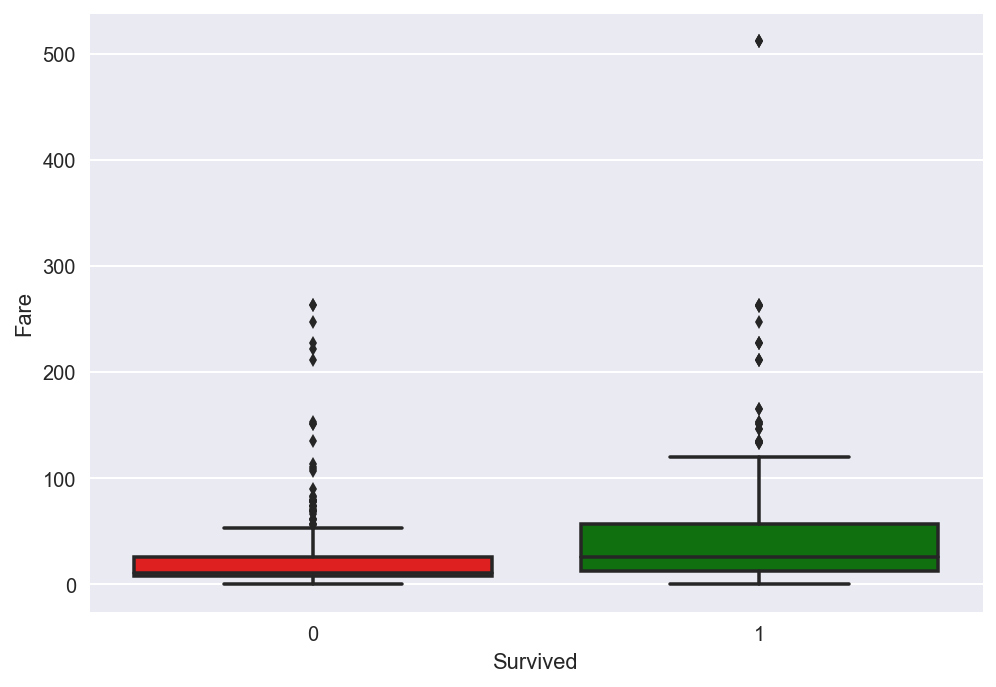

In [161]:
ax = sns.boxplot(x="Survived", y="Fare", data=train, palette={0: 'r', 1: 'g'})

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


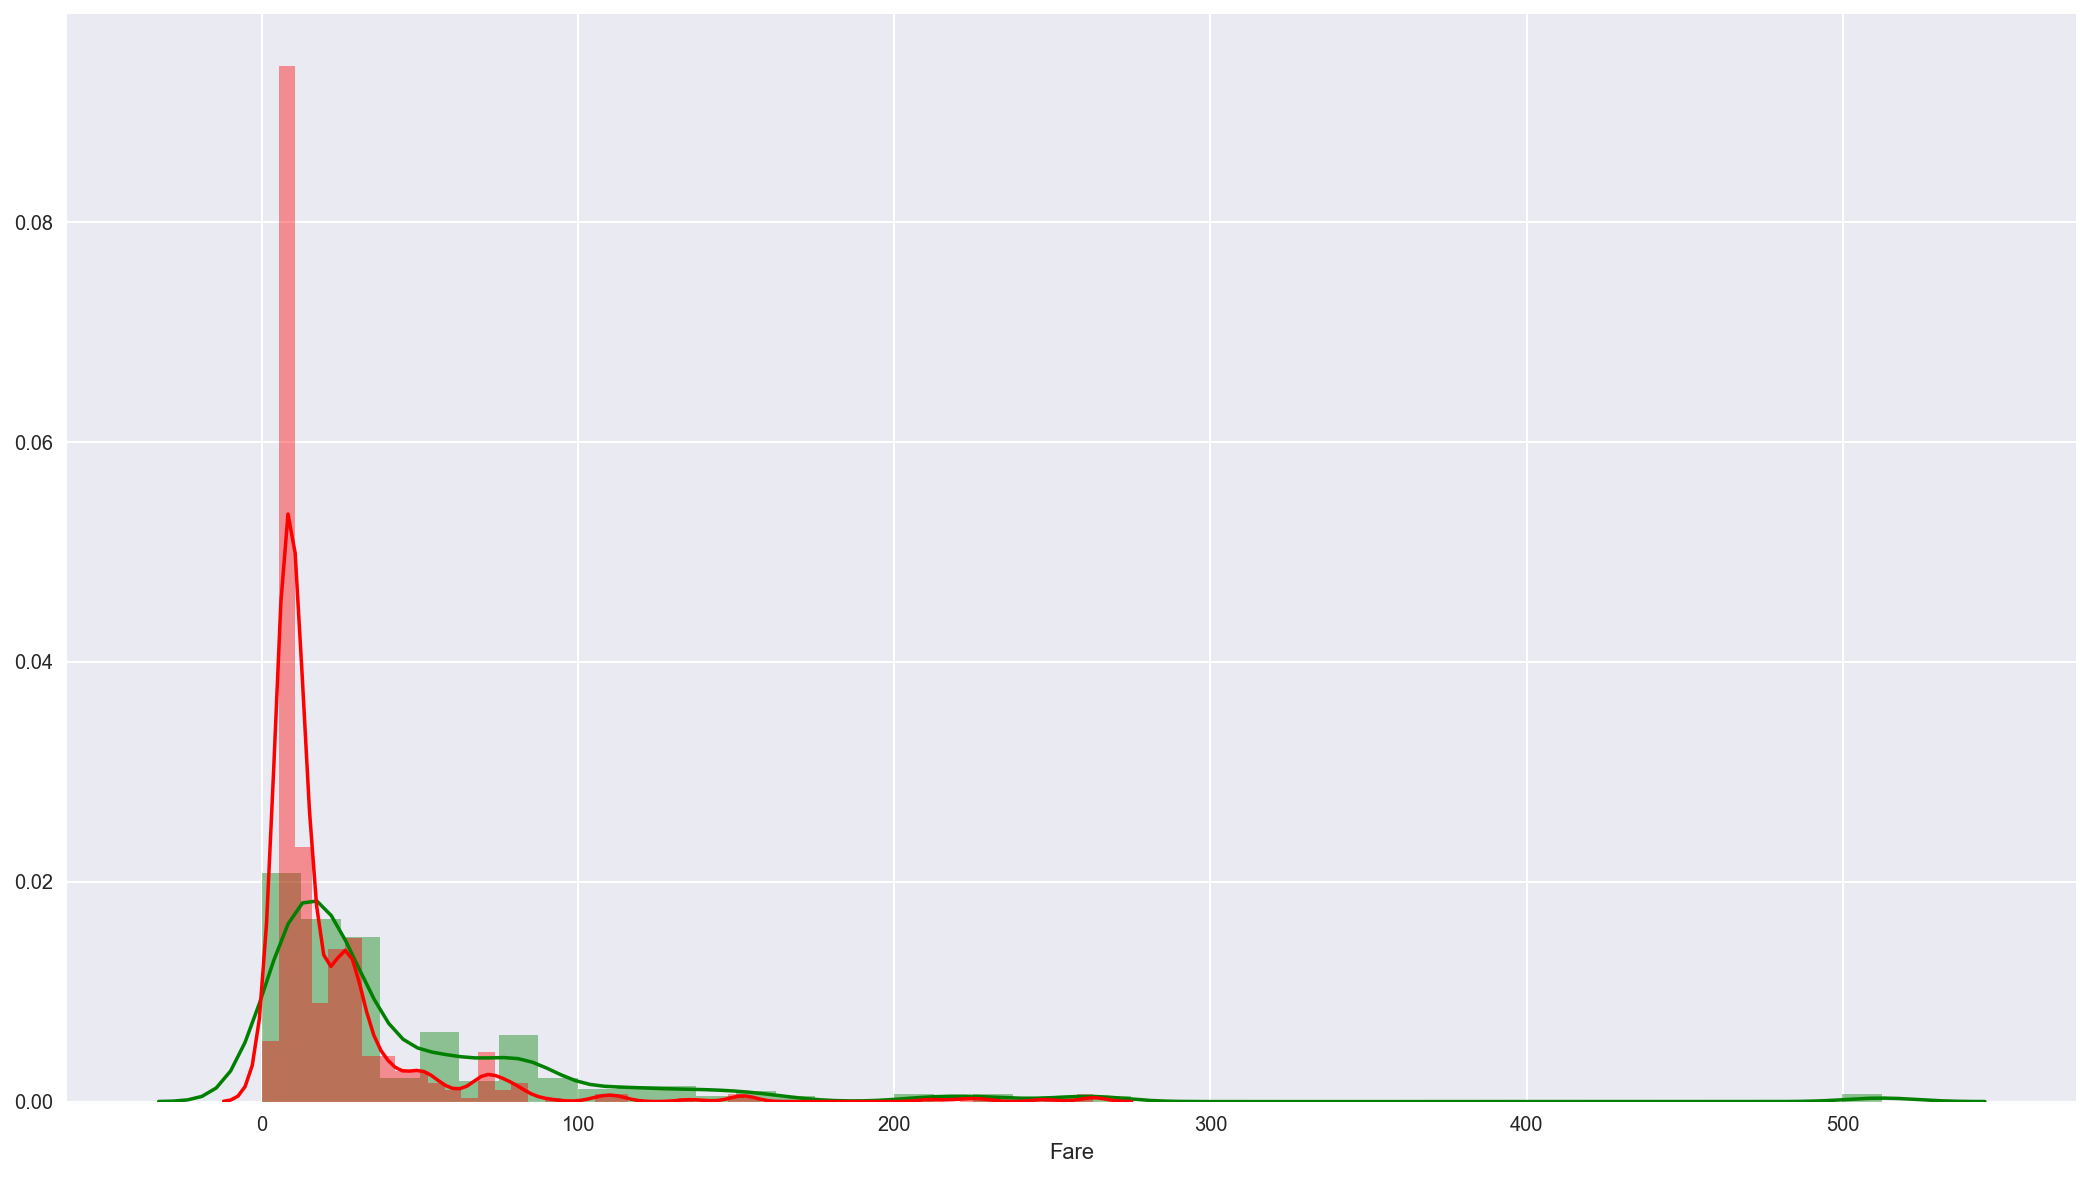

In [171]:
plt.figure(figsize=(18, 10))
sns.distplot(train[train['Survived'] == 1]['Fare'], color='g')
sns.distplot(train[train['Survived'] == 0]['Fare'], color='r')
plt.show()

可以看出，票价比较低的，死亡的人数比较多，因此票价是一个重要的特征。

### 猜测：乘客等级 Pclass 对是否幸存有影响

In [174]:
train['Pclass'].unique()

array([3, 1, 2])

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


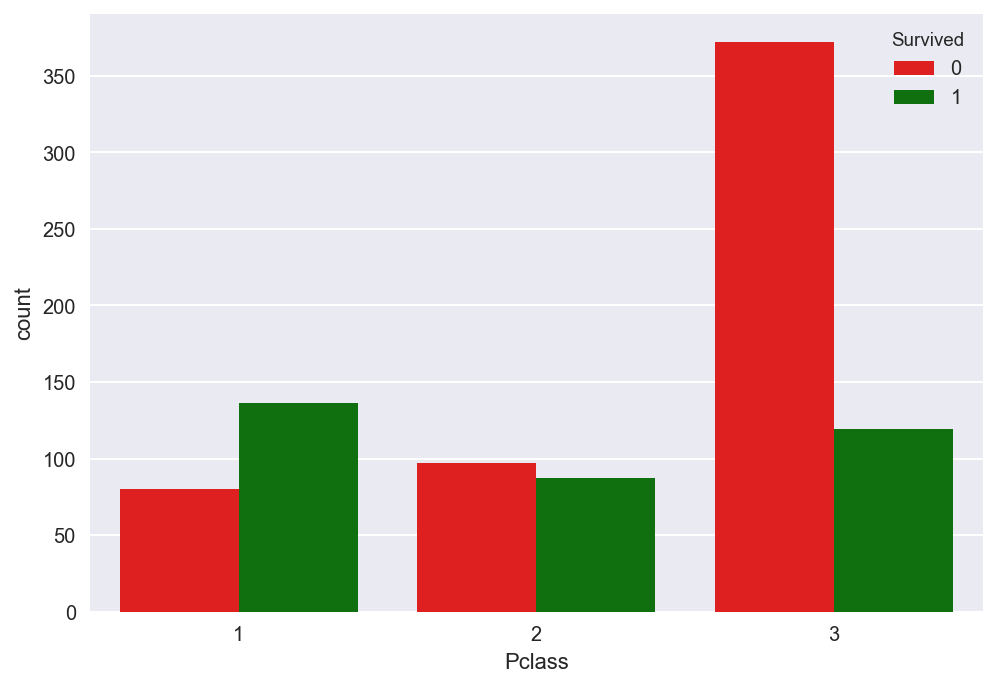

In [186]:
sns.countplot(
    x='Pclass', hue='Survived', palette={0: 'r',
                                           1: 'g'}, data=train)
plt.show()

可以看到，$1$ 号乘客等级幸存者较多， $3$ 号乘客等级死亡比幸存多很多，因此乘客等级是一个预测是否幸存的重要变量。

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


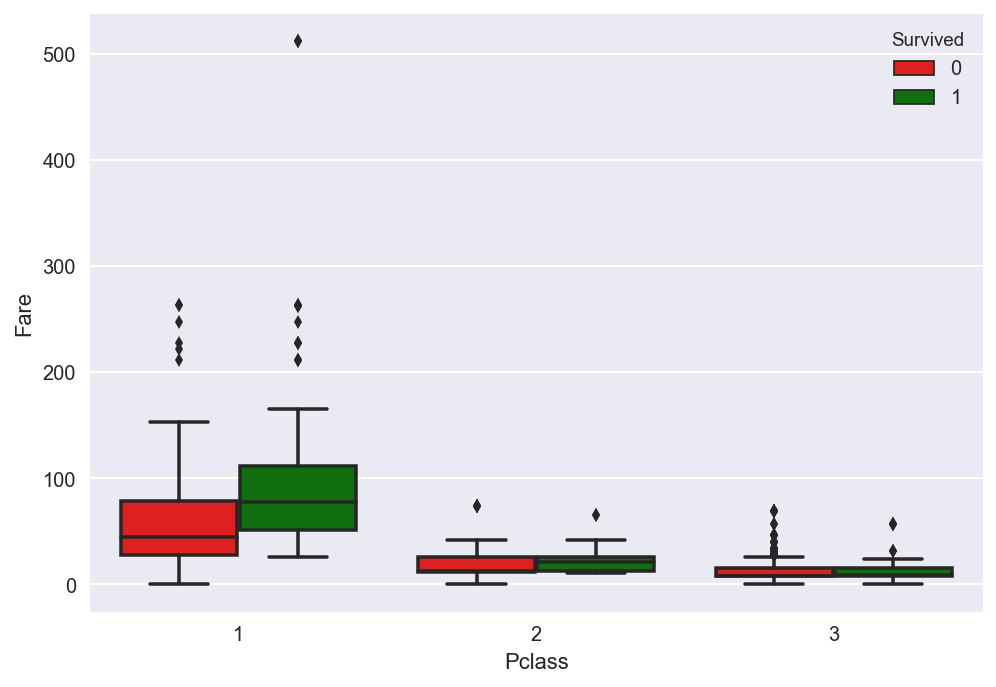

In [180]:
sns.boxplot(
    x='Pclass', y='Fare', data=train, hue='Survived', palette={
        0: 'r',
        1: 'g'
    })
plt.show()

### 猜测：登船港口 Embarked 对是否幸存有影响

In [185]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


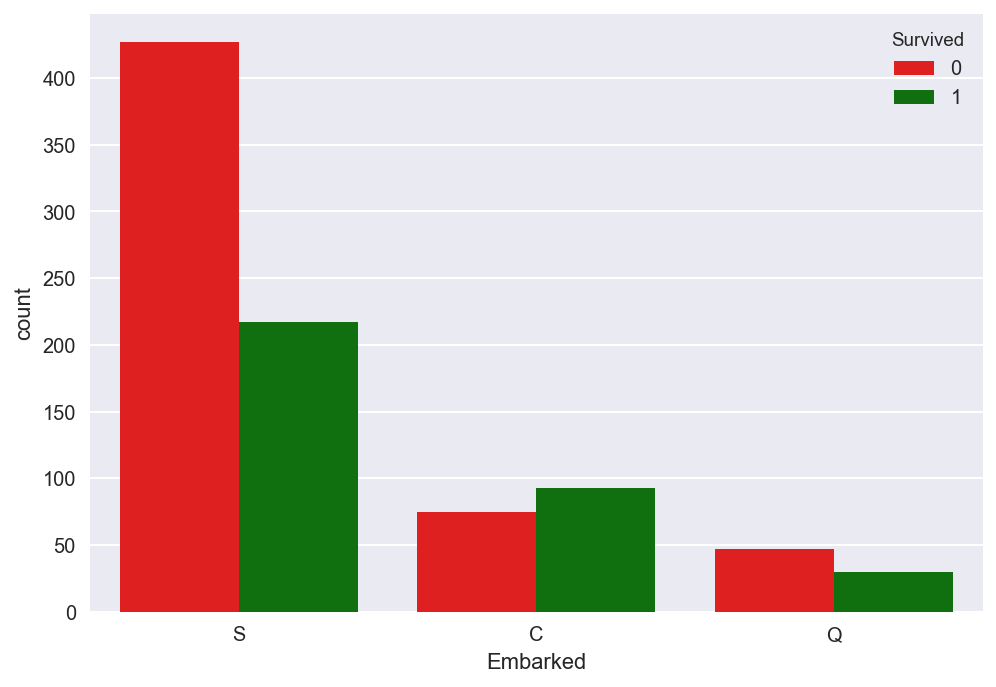

In [183]:
sns.countplot(
    x='Embarked', hue='Survived', palette={0: 'r',
                                           1: 'g'}, data=train)
plt.show()

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


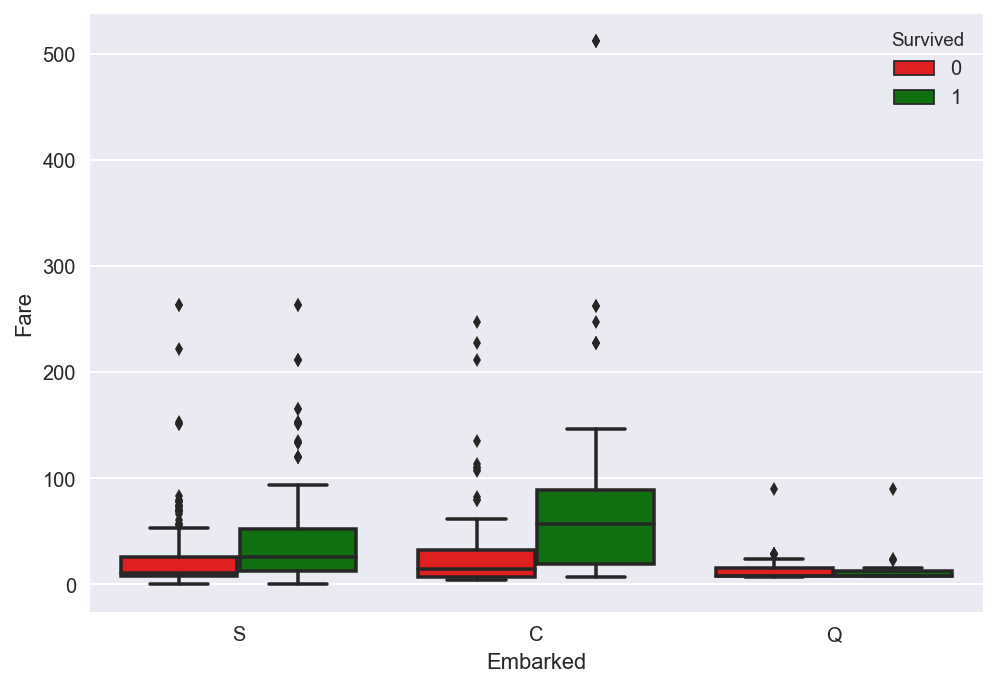

In [184]:
sns.boxplot(
    x='Embarked', y='Fare', data=train, hue='Survived', palette={
        0: 'r',
        1: 'g'
    })

以上我们做的工作就是提出我们的猜想，根据一些数学工具，或者绘图验证我们的猜想，我们的猜想无非就是哪些特征重要、哪些特征不重要。

我们总结一下：

重要的特征有：
1、性别 Sex

2、年龄（可能比较重要） Age

3、票价 Fare

4、乘客等级 Pclass

5、登船港口 Embarked


我个人觉得刚开始做这部分工作的时候，不要纠结在怎么绘图上，其实绘图好坏对最终的模型训练没有什么实质上的帮助，绘图绘制得好，会让你的分析更有说服力。


重点其实在下面这一步：<span class="burk">特征工程</span>。特征工程的操作实实在在影响到最终模型运行的结果。

## 特征工程

我们首先把训练数据集和测试数据集合并起来。

这里要注意：真实的项目是不可以这么做的，因为真实的项目中我们是拿不到测试数据集的。这里这么做只是为了把测试数据集和训练数据集放在一起处理。

In [444]:
def get_combined_data():
    train = pd.read_csv('../Datasets/titanic/train.csv')
    test = pd.read_csv('../Datasets/titanic/test.csv')

    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)

    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

    return combined

In [445]:
combined_data = get_combined_data()
combined_data.shape

(1309, 10)

In [446]:
combined_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [447]:
combined_data[combined_data['Name'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


### 步骤1：从姓名中抽取 title 特征

我们发现姓名里面有 title，title 可能是社会地位的象征，根据这一点，抽取特征

In [448]:
combined_data['title'] = combined_data['Name'].map(
    lambda x: x.split(',')[1].split('.')[0].strip())

In [449]:
# 再根据这些 title 细分，是官员，还是皇室，还是女士、先生、小姐
combined_data['title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [450]:
Title_Dictionary = {
    "Mr": "Mr",
    "Mrs": "Mrs",
    "Miss": "Miss",
    "Master": "Master",
    "Don": "Royalty",
    "Rev": "Officer",
    "Dr": "Officer",
    "Mme": "Mrs",
    "Ms": "Mrs",
    "Major": "Officer",
    "Lady": "Royalty",
    "Sir": "Royalty",
    "Mlle": "Miss",
    "Col": "Officer",
    "Capt": "Officer",
    "the Countess": "Royalty",
    "Jonkheer": "Royalty",
    "Dona": 'Mrs'
}

In [451]:
combined_data['Title'] = combined_data['title'].map(Title_Dictionary)
combined_data['Title'].value_counts()

Mr         757
Miss       262
Mrs        201
Master      61
Officer     23
Royalty      5
Name: Title, dtype: int64

In [452]:
del combined_data['Name']
del combined_data['title']
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


#### 从姓名中抽取出 Title 特征以后，要进行独热编码

In [453]:
titles_dummies = pd.get_dummies(combined_data['Title'], prefix='Title')
titles_dummies.head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


然后，删掉 `Title` 把 `titles_dummies` 拼接上去。

In [454]:
# del combined_data['Title']

In [455]:
combined_data = pd.concat([combined_data, titles_dummies], axis=1)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0,0


### 处理缺失的年龄特征

先分别看一看年龄在训练数据集和测试数据集中缺失了多少。

In [456]:
# 训练数据集中年龄缺失个数
print(combined_data.iloc[:891].Age.isnull().sum())

177


In [457]:
# 测试数据集中年龄缺失个数
print(combined_data.iloc[891:].Age.isnull().sum())

86


可以看到，训练数据集有 177 个缺失值，测试数据集有 86 个缺失值。

从“性别”、“客舱等级” 和 “Title” 可以给乘客做一个聚类，如果落在相同的类别里，就用这个类比的中位数填充。

In [458]:
grouped_train = combined_data.iloc[:891].groupby(['Sex', 'Pclass', 'Title'])
grouped_train.median()['Age']

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64

In [459]:
grouped_median_train = grouped_train.median()['Age'].reset_index()
grouped_median_train

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


这样就做到了，根据乘客不同的信息：“性别”、“客舱” 和 “Title” 填充缺失年龄。这样做，比无脑地直接将缺失的年龄填充成全部数据的中位数要好很多。

下面我们要编写一个函数，即根据一条数据的 “性别”、“客舱” 和 “Title” 到上面的 `grouped_median_train` 中查询对应的值。

In [460]:
def select_group_age_median(row):
    condition = ((row['Sex'] == grouped_median_train['Sex']) &
                 (row['Pclass'] == grouped_median_train['Pclass']) &
                 (row['Title'] == grouped_median_train['Title']))
    return grouped_median_train[condition]['Age'].values[0]

In [461]:
combined_data.iloc[0]['Age']

22.0

In [462]:
select_group_age_median(combined_data.iloc[0])

26.0

+ 针对每一行做一个映射，所以要加上 `axis=1`。

In [463]:
combined_data['Age'] = combined_data.apply(
    lambda x: select_group_age_median(x) if np.isnan(x['Age']) else x['Age'], axis=1)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0,0


In [464]:
# 'Age' 列填充完成
combined_data.describe()

,Pclass,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
count,1309.000000,1309.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,29.213270,0.498854,0.385027,33.295479,0.046600,0.200153,0.578304,0.153552,0.017571,0.003820
std,0.837836,13.400994,1.041658,0.865560,51.758668,0.210862,0.400267,0.494019,0.360657,0.131435,0.061709
min,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,26.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,36.500000,1.000000,0.000000,31.275000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Fare 就一个缺失值，用平均值填充就好了

既然是测试数据缺失了，就用训练数据填充它。

In [465]:
sum(combined_data['Fare'][:891].notnull())

891

In [466]:
sum(combined_data['Fare'][891:].notnull())

417

In [467]:
combined_data[combined_data['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
1043,3,male,60.5,0,0,3701,NaN,NaN,S,Mr,0,0,1,0,0,0


In [468]:
combined_data['Fare'].fillna(combined_data['Fare'][:891].mean(), inplace=True)

In [469]:
combined_data[combined_data['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty


说明没有缺失值了。

In [470]:
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0,0


### 处理 Embarked 字段

Embarked 有两个缺失值，使用众数填充就好了。

In [471]:
combined_data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [472]:
combined_data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [473]:
combined_data[combined_data['Embarked'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
61,1,female,38.0,0,0,113572,80.0,B28,NaN,Miss,0,1,0,0,0,0
829,1,female,62.0,0,0,113572,80.0,B28,NaN,Mrs,0,0,0,1,0,0


In [474]:
combined_data['Embarked'].mode().values[0]

'S'

In [475]:
combined_data['Embarked'].fillna('S', inplace=True)

In [476]:
Embarked_dummies = pd.get_dummies(combined_data['Embarked'], prefix='Embarked')
Embarked_dummies.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [477]:
combined_data = pd.concat([combined_data, Embarked_dummies], axis=1)

In [478]:
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0,0,0,0,1


In [479]:
del combined_data['Embarked']

### 处理 Cabin

In [480]:
combined_data['Cabin']

0               NaN
1               C85
2               NaN
3              C123
4               NaN
5               NaN
6               E46
7               NaN
8               NaN
9               NaN
10               G6
11             C103
12              NaN
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19              NaN
20              NaN
21              D56
22              NaN
23               A6
24              NaN
25              NaN
26              NaN
27      C23 C25 C27
28              NaN
29              NaN
           ...     
1279            NaN
1280            NaN
1281            B24
1282            D28
1283            NaN
1284            NaN
1285            NaN
1286            C31
1287            NaN
1288            B41
1289            NaN
1290            NaN
1291             C7
1292            NaN
1293            NaN
1294            NaN
1295            D40
1296            D38
1297            NaN


看似杂乱无章呀。不过排个序看一看。

In [481]:
combined_data['Cabin'].sort_values()

583      A10
1099     A11
475      A14
556      A16
1222     A18
284      A19
599      A20
919      A21
630      A23
867      A24
647      A26
1003     A29
209      A31
185      A32
1184     A34
1265     A34
445      A34
806      A36
96        A5
23        A6
174       A7
937       A9
1057     B10
737     B101
815     B102
1106     B11
523      B18
329      B18
170      B19
781      B20
        ... 
1268     NaN
1270     NaN
1271     NaN
1272     NaN
1273     NaN
1274     NaN
1275     NaN
1276     NaN
1277     NaN
1278     NaN
1279     NaN
1280     NaN
1283     NaN
1284     NaN
1285     NaN
1287     NaN
1289     NaN
1290     NaN
1292     NaN
1293     NaN
1294     NaN
1297     NaN
1299     NaN
1300     NaN
1301     NaN
1303     NaN
1304     NaN
1306     NaN
1307     NaN
1308     NaN
Name: Cabin, Length: 1309, dtype: object

In [482]:
combined_data.Cabin.shape

(1309,)

In [483]:
combined_data.Cabin.value_counts().sum()

295

In [484]:
combined_data.shape

(1309, 18)

In [485]:
combined_data[combined_data.Cabin.isnull()].shape

(1014, 18)

缺失很多。

In [486]:
295 + 1014

1309

把缺失的都填充成 `U` ，就是 `unknown` 的意思。

In [487]:
combined_data['Cabin'].fillna('U', inplace=True)

In [488]:
combined_data['Cabin'] = combined_data['Cabin'].map(lambda x: x[0])
combined_data['Cabin']

0       U
1       C
2       U
3       C
4       U
5       U
6       E
7       U
8       U
9       U
10      G
11      C
12      U
13      U
14      U
15      U
16      U
17      U
18      U
19      U
20      U
21      D
22      U
23      A
24      U
25      U
26      U
27      C
28      U
29      U
       ..
1279    U
1280    U
1281    B
1282    D
1283    U
1284    U
1285    U
1286    C
1287    U
1288    B
1289    U
1290    U
1291    C
1292    U
1293    U
1294    U
1295    D
1296    D
1297    U
1298    C
1299    U
1300    U
1301    U
1302    C
1303    U
1304    U
1305    C
1306    U
1307    U
1308    U
Name: Cabin, Length: 1309, dtype: object

In [489]:
combined_data['Cabin'].value_counts()

U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

In [490]:
# 组合出独热编码
cabin_dummies = pd.get_dummies(combined_data['Cabin'], prefix='Cabin')
combined_data = pd.concat([combined_data, cabin_dummies], axis=1)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title,Title_Master,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,U,Mr,0,...,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C,Mrs,0,...,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,U,Miss,0,...,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C,Mrs,0,...,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,U,Mr,0,...,1,0,0,0,0,0,0,0,0,1


In [491]:
del combined_data['Cabin']

### 处理性别，因为是二值数据，直接使用 1 和 0 替换即可

In [492]:
# 只能执行一次，还是用 lambda 表达式会好一些
def deal_with_sex(x):
    if x:
        return 1 if x == 'male' else '0'

combined_data['Sex'] = combined_data['Sex'].map(deal_with_sex)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title,Title_Master,Title_Miss,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,1,22.0,1,0,A/5 21171,7.2500,Mr,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,Mrs,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,Miss,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,0,35.0,1,0,113803,53.1000,Mrs,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,1,35.0,0,0,373450,8.0500,Mr,0,0,...,1,0,0,0,0,0,0,0,0,1


### 处理 Pclass

In [493]:
Pclass_dummies = pd.get_dummies(combined_data['Pclass'], prefix='Pclass')
Pclass_dummies.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [494]:
combined_data = pd.concat([combined_data, Pclass_dummies], axis=1)
combined_data.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title,Title_Master,Title_Miss,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,3,1,22.0,1,0,A/5 21171,7.2500,Mr,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,Mrs,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,Miss,0,1,...,0,0,0,0,0,0,1,0,0,1
3,1,0,35.0,1,0,113803,53.1000,Mrs,0,0,...,1,0,0,0,0,0,0,1,0,0
4,3,1,35.0,0,0,373450,8.0500,Mr,0,0,...,0,0,0,0,0,0,1,0,0,1


### 处理 Ticket

为了简化，暂时不处理了，认为这是一个无效的特征。实际上还是有高手，从票价信息中，分析出了有用的特征。

In [495]:
combined_data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [496]:
del combined_data['Title']

### 从 SibSp 和 Parch 中抽取出新特征“家庭规模”

In [500]:
combined_data['FamilySize'] = combined_data['SibSp'] + combined_data['Parch'] + 1
combined_data['FamilySize'].head()

0    2
1    2
2    1
3    2
4    1
Name: FamilySize, dtype: int64

In [502]:
# 看看最大值和最小值
combined_data['FamilySize'].describe()

count    1309.000000
mean        1.883881
std         1.583639
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        11.000000
Name: FamilySize, dtype: float64

我们人为划定一个家庭规模标准。

In [506]:
def deal_with_family_size(num):
    if num == 1:
        return 'Singleton'
    elif num <= 4:
        return 'SmallFamily'
    elif num >= 5:
        return 'LargeFamily'
    return num

FamilySize_dummies = pd.get_dummies(combined_data['FamilySize'].map(deal_with_family_size), prefix='FamilySize')
FamilySize_dummies.head()

,FamilySize_LargeFamily,FamilySize_Singleton,FamilySize_SmallFamily
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,1,0


In [507]:
combined_data = pd.concat([combined_data, FamilySize_dummies], axis=1)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,FamilySize,FamilySize_LargeFamily,FamilySize_Singleton,FamilySize_SmallFamily
0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,1,...,0,0,1,0,0,1,2,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,2,0,0,1
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,0,0,1,0,0,1,1,0,1,0
3,1,0,35.0,1,0,113803,53.1000,0,0,0,...,0,0,0,1,0,0,2,0,0,1
4,3,1,35.0,0,0,373450,8.0500,0,0,1,...,0,0,1,0,0,1,1,0,1,0
5,3,1,26.0,0,0,330877,8.4583,0,0,1,...,0,0,1,0,0,1,1,0,1,0
6,1,1,54.0,0,0,17463,51.8625,0,0,1,...,0,0,0,1,0,0,1,0,1,0
7,3,1,2.0,3,1,349909,21.0750,1,0,0,...,0,0,1,0,0,1,5,1,0,0
8,3,0,27.0,0,2,347742,11.1333,0,0,0,...,0,0,1,0,0,1,3,0,0,1
9,2,0,14.0,1,0,237736,30.0708,0,0,0,...,0,0,1,0,1,0,2,0,0,1


In [508]:
del combined_data['Ticket']
del combined_data['FamilySize']

In [510]:
del combined_data['Pclass']

In [511]:
combined_data

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,FamilySize_LargeFamily,FamilySize_Singleton,FamilySize_SmallFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
5,1,26.0,0,0,8.4583,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
6,1,54.0,0,0,51.8625,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
7,1,2.0,3,1,21.0750,1,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
8,0,27.0,0,2,11.1333,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
9,0,14.0,1,0,30.0708,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1


## 建模

In [512]:
combined_data.shape

(1309, 29)

### 分离训练数据集和验证数据集

In [515]:
X_train = combined_data.iloc[:891]
X_test = combined_data.iloc[891:]

In [520]:
y_train = train_age['Survived']

### 使用随机森林得到特征的重要程度

In [522]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_estimators=50, max_features='sqrt')
rfc = rfc.fit(X_train, y_train)

In [524]:
rfc.feature_importances_

array([8.32696628e-02, 1.96613987e-01, 2.96454906e-02, 2.32016227e-02,
       2.17408032e-01, 9.55737622e-03, 3.73170509e-02, 1.38653686e-01,
       3.92896197e-02, 6.96278382e-03, 7.82214470e-04, 1.30982675e-02,
       7.33005568e-03, 1.31814233e-02, 2.62802104e-03, 5.08256599e-03,
       6.93650103e-03, 6.90694558e-03, 8.35282209e-03, 1.19666682e-03,
       1.63775943e-03, 1.98981228e-04, 2.32841183e-02, 1.52272332e-02,
       1.21084273e-02, 4.99696213e-02, 1.63296604e-02, 1.35438299e-02,
       2.02855742e-02])

In [525]:
X_train.columns

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'FamilySize_LargeFamily',
       'FamilySize_Singleton', 'FamilySize_SmallFamily'],
      dtype='object')

In [527]:
feature_importances = pd.Series(rfc.feature_importances_,X_train.columns)

In [536]:
feature_importances.sort_values(ascending=False, inplace=True)

In [537]:
feature_importances

Fare                      0.217408
Age                       0.196614
Title_Mr                  0.138654
Sex                       0.083270
Pclass_3                  0.049970
Title_Mrs                 0.039290
Title_Miss                0.037317
SibSp                     0.029645
Cabin_U                   0.023284
Parch                     0.023202
FamilySize_SmallFamily    0.020286
FamilySize_LargeFamily    0.016330
Pclass_1                  0.015227
FamilySize_Singleton      0.013544
Embarked_S                0.013181
Embarked_C                0.013098
Pclass_2                  0.012108
Title_Master              0.009557
Cabin_E                   0.008353
Embarked_Q                0.007330
Title_Officer             0.006963
Cabin_C                   0.006937
Cabin_D                   0.006907
Cabin_B                   0.005083
Cabin_A                   0.002628
Cabin_G                   0.001638
Cabin_F                   0.001197
Title_Royalty             0.000782
Cabin_T             

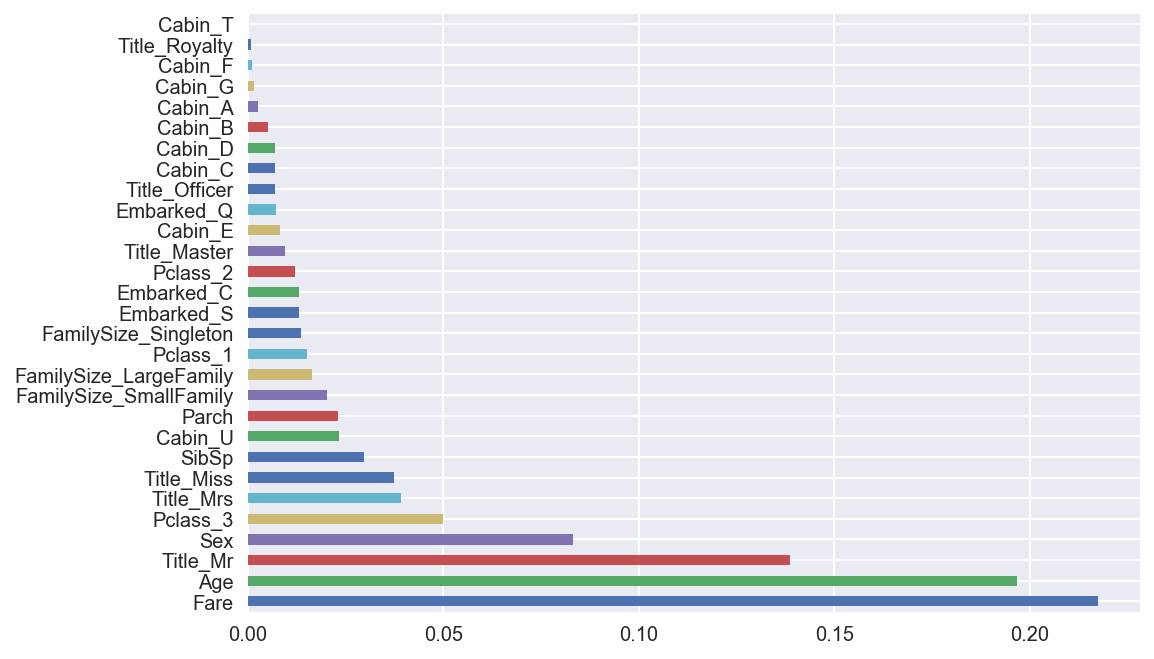

In [538]:
feature_importances.plot(kind='barh')

### 使用 SelectFromModel 这个类找到重要的特征

注意：这个类来自特征选择。

> Meta-transformer for selecting features based on importance weights.

传入这个类的模型，必须要有 `feature_importances_` 这个属性。

In [542]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(rfc, prefit=True)
train_reduced = sfm.transform(X_train)

In [558]:
train_reduced.shape

(891, 7)

In [564]:
np.set_printoptions(linewidth=100, suppress=True)
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.nan)
train_reduced

array([[  1.    ,  22.    ,   7.25  ,   0.    ,   1.    ,   0.    ,   1.    ],
       [  0.    ,  38.    ,  71.2833,   0.    ,   0.    ,   1.    ,   0.    ],
       [  0.    ,  26.    ,   7.925 ,   1.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  35.    ,  53.1   ,   0.    ,   0.    ,   1.    ,   0.    ],
       [  1.    ,  35.    ,   8.05  ,   0.    ,   1.    ,   0.    ,   1.    ],
       [  1.    ,  26.    ,   8.4583,   0.    ,   1.    ,   0.    ,   1.    ],
       [  1.    ,  54.    ,  51.8625,   0.    ,   1.    ,   0.    ,   0.    ],
       [  1.    ,   2.    ,  21.075 ,   0.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  27.    ,  11.1333,   0.    ,   0.    ,   1.    ,   1.    ],
       [  0.    ,  14.    ,  30.0708,   0.    ,   0.    ,   1.    ,   0.    ],
       [  0.    ,   4.    ,  16.7   ,   1.    ,   0.    ,   0.    ,   1.    ],
       [  0.    ,  58.    ,  26.55  ,   1.    ,   0.    ,   0.    ,   0.    ],
       [  1.    ,  20.    ,   8.05  ,   0.    ,   1.

### 得到的重要的特征以后，我们就要把数据送入算法了

我们没有调参，使用默认的参数。

In [567]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

In [568]:
# 把这些模型放进一个列表中
models = [logreg, logreg_cv, rf, gboost]

In [570]:
from sklearn.model_selection import cross_val_score

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = cross_val_score(estimator=model, X=train_reduced, y=y_train, scoring='accuracy')
    print('CV score = {0}'.format(score.mean()))
    print('******')


Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.7833894500561168
******
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.7822671156004489
******
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.809203142536476
******
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8159371492704826
******


In [574]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()
score = cross_val_score(estimator=xgboost_clf, X=train_reduced, y=y_train, scoring='accuracy')
print(score.mean())

0.8294051627384961


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 使用网格搜索对随机森林调参

In [575]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

NameError: name 'targets' is not defined